# Esercizio 11.2

Polinomial Regression with neural network (NN)
$$
y=4-3x-2x^2+3x^3
$$

using default parameters for NN training

- N_train=500
- N_valid=50
- N_epoch=100
- sigma=0.1

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


In [26]:
a=4
b=-3
c=-2
d=3
#fixed values for training and data
N_train=500
N_valid=int(50)
N_epoch=100
sigma=0.1

def Generate_Data():
  '''
  generate data for traing and validation of NN
  y=a+bx+cx^2+dx^3
  with a gaussian noise
  '''
  np.random.seed(0)
  x_train = np.random.uniform(-1, 1, N_train)
  x_valid = np.random.uniform(-1, 1, N_valid)
  x_valid.sort()
  y_target =a+b*np.power(x_valid,1)+c*np.power(x_valid,2)+d*np.power(x_valid,3) # ideal (target) linear function
  y_train = np.random.normal(a+b*np.power(x_train,1)+c*np.power(x_train,2)+d*np.power(x_train,3), sigma) # actual measures from which we want to guess regression parameters
  y_valid = np.random.normal(a+b*np.power(x_valid,1)+c*np.power(x_valid,2)+d*np.power(x_valid,3), sigma)
  data={
      "x_train": x_train,
      "y_train": y_train,
      "x_valid": x_valid,
      "y_valid": y_valid,
      "y_target": y_target
       }
  return data

def Generate_Model(N_layer=1,N_neuron=2,opt="sgd", loss='mse', act='relu'):
  '''
  generate NN model with N_layers, N_neurons per layer with activation funcition and 1 outpu layer with linear activation
  '''
  model = tf.keras.Sequential()
  model.add(Dense(N_neuron, kernel_initializer='normal',input_shape=(1,),activation=act))
  
  # The Hidden Layers :
  for i in range(N_layer):
    model.add(Dense(N_neuron,kernel_initializer='normal', activation=act))
  
  # The Output Layer :
  model.add(Dense(1, kernel_initializer='normal',activation='linear'))
  model.compile(optimizer=opt, loss=loss, metrics=['mse'])

  return model


def NN_test(N_layer=1,N_neuron=2,opt="sgd", loss='mse', act='relu'):
  '''
  generate data, a neural network model and tests it
  input: number of layers, number of neurons, optimizer, loss, activation function
  output: data generated, history of the model, score with validation data, score with exact curve, score for validation data 
  outside the training range and the model
  '''
  data=Generate_Data()
  model=Generate_Model(N_layer,N_neuron,opt, loss, act)
  history = model.fit(x=data["x_train"], y=data["y_train"], 
          batch_size=32, epochs=N_epoch,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(data["x_valid"], data["y_valid"]))

  # evaluate
  score = model.evaluate(data["x_valid"], data["y_valid"], batch_size=32, verbose=1)
  score_ec = model.evaluate(data["x_valid"], data["y_target"], batch_size=32, verbose=1)

  x_out = np.random.uniform(-1.3, 1.3, 100)
  x_out.sort()
  y_target_out =a+b*np.power(x_out,1)+c*np.power(x_out,2)+d*np.power(x_out,3) 

  indices=np.where( np.logical_or(x_out<-1 , x_out>1 ) )
  score_out=model.evaluate(x_out[indices] , y_target_out[indices] , batch_size=32, verbose=1)

  # print performance
  print()
  print('Test loss:   data_test=', score[0], "  exact curve=", score_ec[0])
  print('Test accuracy:   data_test=', score[1], "  exact curve=", score_ec[1])

  return([data,history,score[0],score_ec[0], score_out[0], model])



def Find_best_NN(N_layers, N_neurons, opt="sgd", loss='mse', act='relu'):
  '''
  Input=NN model parameters
  Test the neural network for different values of N_layers, N_neurons for defined opt, loss, act
  and give in output al the training values and the best NN 
  Output= TEST : list of all values relative the test
          history: history of the best NN run
          data: all data relative to values of the best run 
          model: best NN model
          best number of layers
          best number of neurons
  '''

  v=["N_layers","N_neurons","opt","act", "loss", "loss_VD","loss_EC", 'loss_out']
  TEST=pd.DataFrame(columns=v)
  for N_layer in N_layers:
    i=0
    
    for N_neuron in N_neurons:
      data,history, test_loss, loss_ec, loss_out, model=NN_test(N_layer,N_neuron,opt, loss, act)
      i=i+1

      if(N_neuron==N_neurons[0] and N_layer==N_layers[0]):
        N_layer_best=N_layer
        N_neuron_best=N_neuron
        data_best=data 
        history_best=history 
        model_best=model
        loss_check=test_loss

      if test_loss<loss_check:
        N_layer_best=N_layer
        N_neuron_best=N_neuron
        data_best=data 
        history_best=history 
        model_best=model
        loss_check=test_loss

      TEST.loc[len(TEST.index)] = [N_layer, N_neuron, opt,act,loss, test_loss, loss_ec, loss_out]

  return TEST, history_best, data_best, model_best, N_neuron_best, N_layer_best

In [27]:
def plot_NN(history, data, model):
  fig,ax=plt.subplots(1,2,figsize=(15,6))
  ax[0].plot(history.history['loss'])
  ax[0].plot(history.history['val_loss'])
  ax[0].set_title('Model loss')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Test'], loc='best')
  ax[0].grid(True)

  x_predicted = np.random.uniform(-1, 1, 100)
  y_predicted = model.predict(x_predicted)[0:,0]
  ax[1].scatter(data["x_train"], data["y_train"], alpha=0.5,color="yellow", label="train data")
  ax[1].scatter(x_predicted, y_predicted,color='r', label="model prediction")
  ax[1].set_title('Prediction')
  ax[1].plot(data["x_valid"], data["y_target"], label="target data")
  ax[1].set_xlabel("x")
  ax[1].set_ylabel("y")
  ax[1].legend()
  ax[1].grid(True)
  plt.show()

def plot_out(NN):
  TEST, history, data, model, N_neuron, N_layers=NN
  fig,ax=plt.subplots(1,1,figsize=(10,6))
  x_predicted = np.random.uniform(-1.3, 1.3, 100)
  x_predicted.sort()
  y_target =a+b*np.power(x_predicted,1)+c*np.power(x_predicted,2)+d*np.power(x_predicted,3) # ideal (target) linear function
  y_predicted = model.predict(x_predicted)[0:,0]
  ax.scatter(data["x_train"], data["y_train"], alpha=0.5,color="yellow", label="train data")
  ax.scatter(x_predicted, y_predicted,color='r', label="model prediction")
  ax.plot(x_predicted, y_target, label="target data")
  ax.set_title('Prediction out of training range')
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.legend()
  ax.grid(True)
  plt.show()

def plot_out2(data, model):
  fig,ax=plt.subplots(1,1,figsize=(10,6))
  x_predicted = np.random.uniform(-1.3, 1.3, 100)
  x_predicted.sort()
  y_target =a+b*np.power(x_predicted,1)+c*np.power(x_predicted,2)+d*np.power(x_predicted,3) # ideal (target) linear function
  y_predicted = model.predict(x_predicted)[0:,0]
  ax.scatter(data["x_train"], data["y_train"], alpha=0.5,color="yellow", label="train data")
  ax.scatter(x_predicted, y_predicted,color='r', label="model prediction")
  ax.plot(x_predicted, y_target, label="target data")
  ax.set_title('Prediction out of training range')
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.legend()
  ax.grid(True)
  plt.show()


def plot_grid(TEST):
  Loss_VD =np.zeros( (len(N_layers) ,len(N_neurons)))
  Loss_EC =np.zeros( (len(N_layers) ,len(N_neurons)))
  Loss_out=np.zeros( (len(N_layers) ,len(N_neurons)))
  i=0
  for N_layer in N_layers:
      Loss_VD[i]=TEST.loc[TEST["N_layers"]==N_layer, "loss_VD"].to_numpy()
      Loss_EC[i]=TEST.loc[TEST["N_layers"]==N_layer, 'loss_EC'].to_numpy()
      Loss_out[i]=TEST.loc[TEST["N_layers"]==N_layer, 'loss_out'].to_numpy()

      i=i+1
  Loss_VD=np.array(Loss_VD)
  Loss_EC=np.array(Loss_EC)
  Loss_out=np.array(Loss_out)

  MAX=np.max([np.max(Loss_VD), np.max(Loss_EC)])

  plt.figure(figsize=(19,5))
  extent = np.min(N_neurons), np.max(N_neurons), np.max(N_layers), np.min(N_layers)

  plt.subplot(131)
  plt.imshow(Loss_VD, extent=extent,vmin=0, vmax=MAX, cmap='jet', aspect='auto')
  plt.title("validation data loss")
  plt.xlabel("# neurons")
  plt.ylabel("# layers")
  plt.colorbar()

  plt.subplot(132)
  plt.imshow(Loss_EC, extent=extent,vmin=0, vmax=MAX, cmap='jet', aspect= 'auto')
  plt.title("exact curve loss")
  plt.xlabel("# neurons")
  plt.ylabel("# layers")
  plt.colorbar()

  plt.subplot(133)
  plt.imshow(Loss_out, extent=extent,vmin=0, vmax= np.max(Loss_out), cmap='jet', aspect= 'auto')
  plt.title("out training range loss")
  plt.xlabel("# neurons")
  plt.ylabel("# layers")
  plt.colorbar()
  plt.show()

def plot(NN):
  TEST, history_best, data_best, model_best, N_neuron_best, N_layers_best=NN
  plot_grid(TEST)
  print()
  print()
  print()
  print("BEST MODEL")
  print("best number of layers=",N_layers_best,"  best number of neurons",  N_neuron_best)
  plot_NN(history_best, data_best, model_best)



-----------------------------------------------------------------

QUICK TEST

In [ ]:
N_layers=15
N_neurons=700
opt='sgd'
loss='mse'
act="relu"

In [ ]:
data=Generate_Data()
model = Generate_Model(N_layers,N_neurons,opt, loss, act)
history = model.fit(x=data["x_train"], y=data["y_train"], 
        batch_size=32, epochs=N_epoch,
        shuffle=True, # a good idea is to shuffle input before at each epoch
        validation_data=(data["x_valid"], data["y_valid"]))

# evaluate
score = model.evaluate(data["x_valid"], data["y_valid"], batch_size=32, verbose=1)
score_ec = model.evaluate(data["x_valid"], data["y_target"], batch_size=32, verbose=1)

# print performance
print()
print('Test loss:   data_test=', score[0], "  exact curve=", score_ec[0])
print('Test accuracy:   data_test=', score[1], "  exact curve=", score_ec[1])

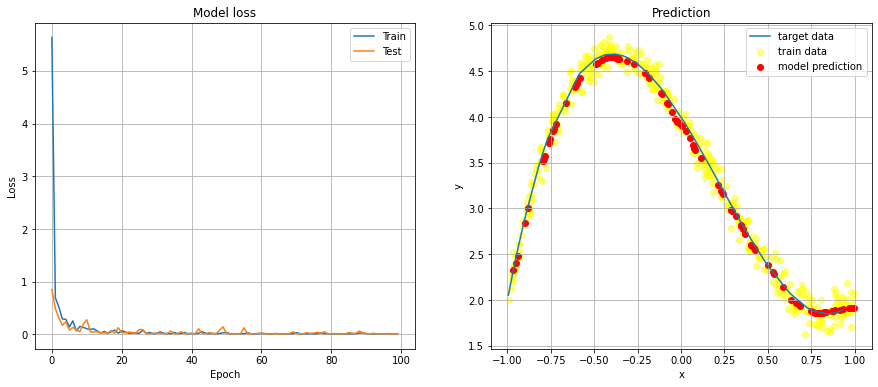

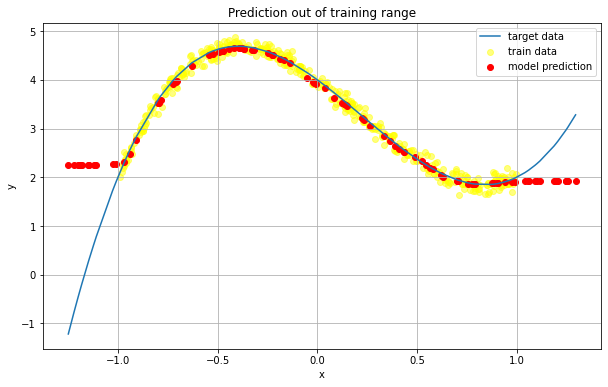

In [ ]:
#model.summary()
plot_NN(history, data, model)
plot_out2(data, model)

---------------------------------------

### TESTING NN for different values of N_layers and N_neurons

N_layers=[1,2,3,4,5,6]

N_neurons=[50,100,150,200,250,300,350]

In [28]:
N_layers=np.arange(1,7, 1)
N_neurons=np.arange(50,400, 50)
print('N_layers=',N_layers)
print('N_neurons=',N_neurons)


N_layers= [1 2 3 4 5 6]
N_neurons= [ 50 100 150 200 250 300 350]


In [ ]:
opt="sgd"
loss='mse'
act='elu'
NN1=Find_best_NN(N_layers, N_neurons, opt, loss, act)

In [ ]:
opt="sgd"
loss='mse'
act='relu'
NN2=Find_best_NN(N_layers, N_neurons, opt, loss, act)

In [ ]:
opt="sgd"
loss='mse'
act='tanh'
NN3=Find_best_NN(N_layers, N_neurons, opt, loss, act)

In [ ]:
opt="sgd"
loss='mse'
act='softplus'
NN4=Find_best_NN(N_layers, N_neurons, opt, loss, act)

In [ ]:
opt="sgd"
loss='mse'
act='sigmoid'
NN5=Find_best_NN(N_layers, N_neurons, opt, loss, act)

---------------------
## activation function: ELU
- opt=sdg
- loss= mse
- act =elu

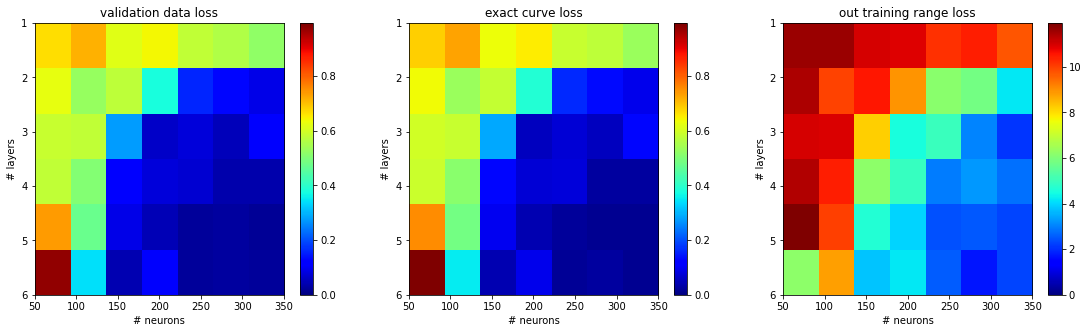




BEST MODEL
best number of layers= 5   best number of neurons 350


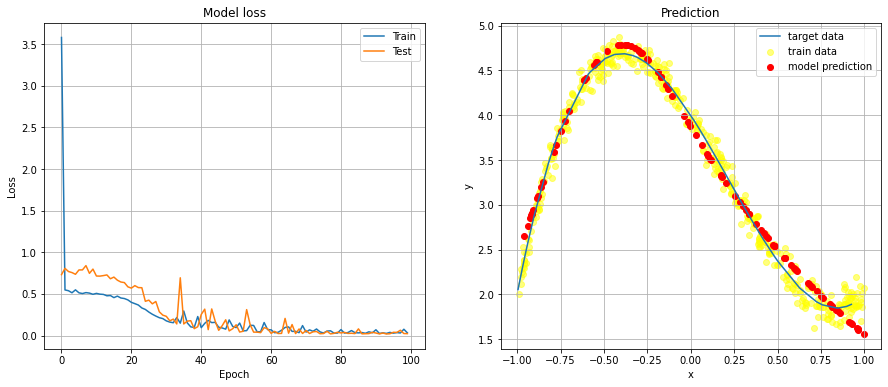

In [15]:
plot(NN1)

PREDICTION OUT OF TRAINING RANGE

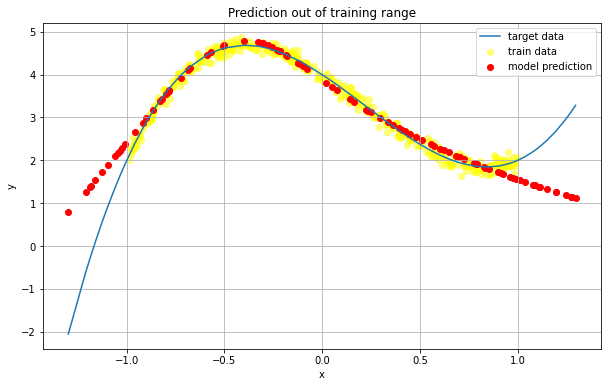

In [16]:
plot_out(NN1)

---------------------
## Activation function: RELU
- opt=sdg
- loss= mse
- act =relu

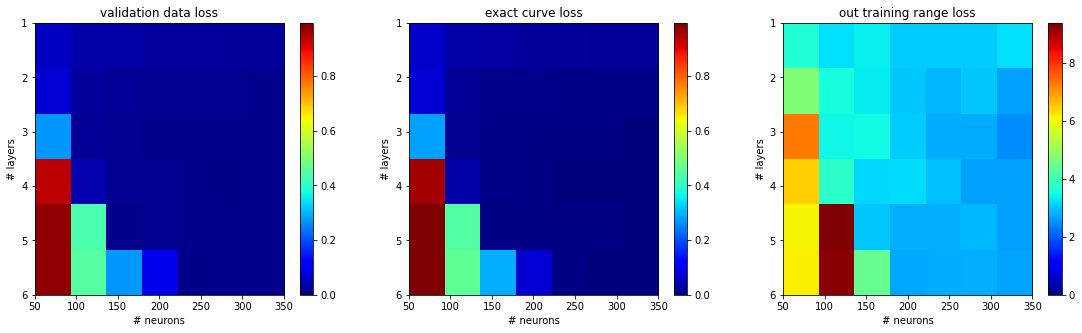




BEST MODEL
best number of layers= 6   best number of neurons 250


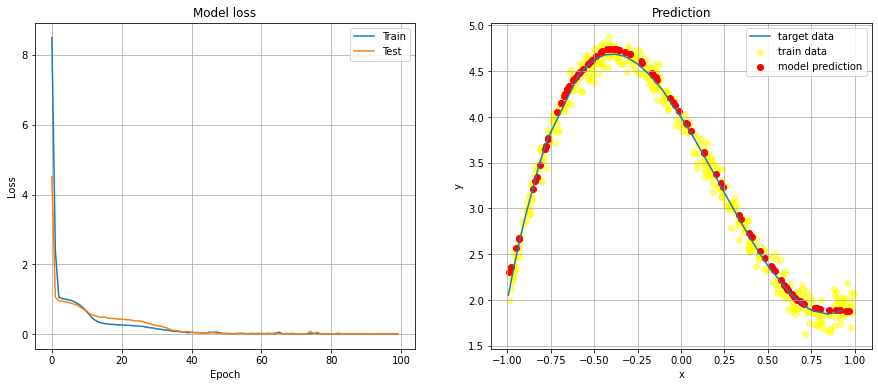

In [17]:
plot(NN2)

PREDICTION OUT OF TRAINING RANGE

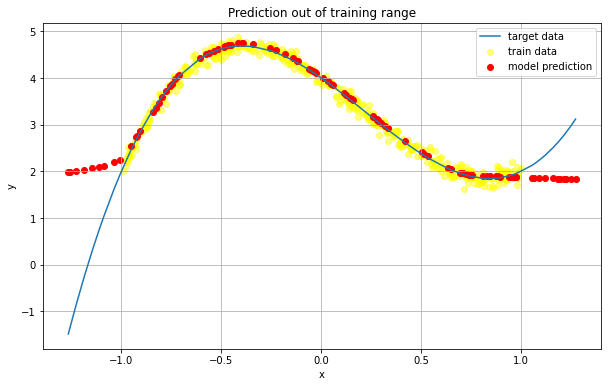

In [18]:
plot_out(NN2)

---------------------
## Activation function: TANH
- opt=sdg
- loss= mse
- act =tanh

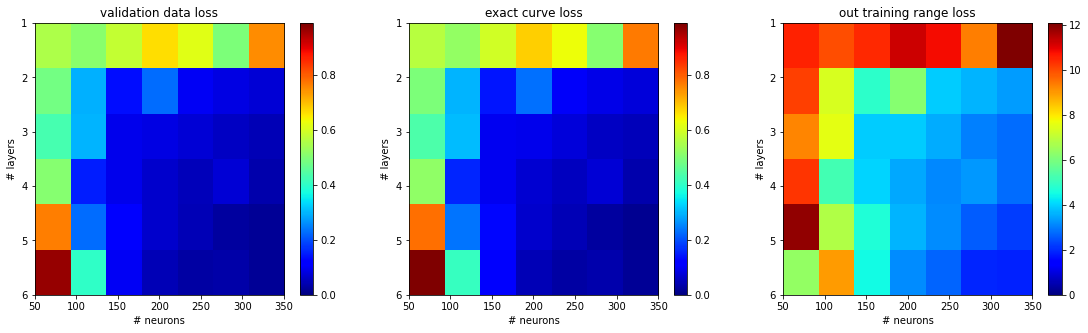




BEST MODEL
best number of layers= 5   best number of neurons 350


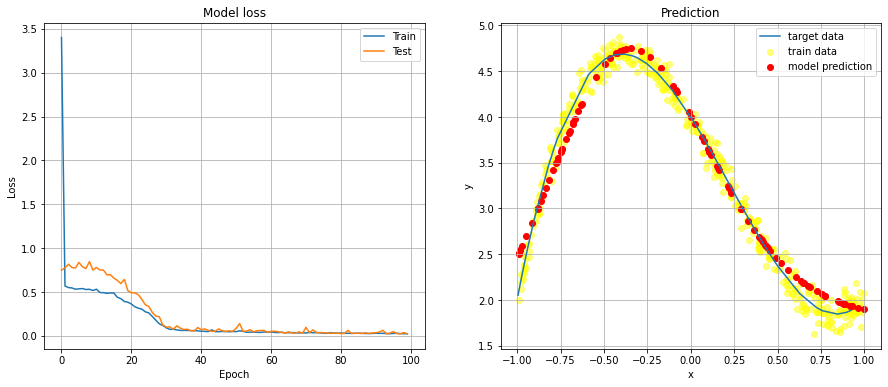

In [19]:
plot(NN3)

PREDICTION OUT OF TRAINING RANGE

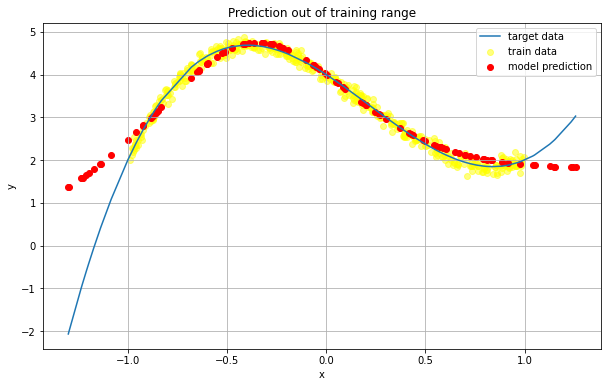

In [20]:
plot_out(NN3)

---------------------
## Activation function: SOFTPLUS
- opt=sdg
- loss= mse
- act =softplus

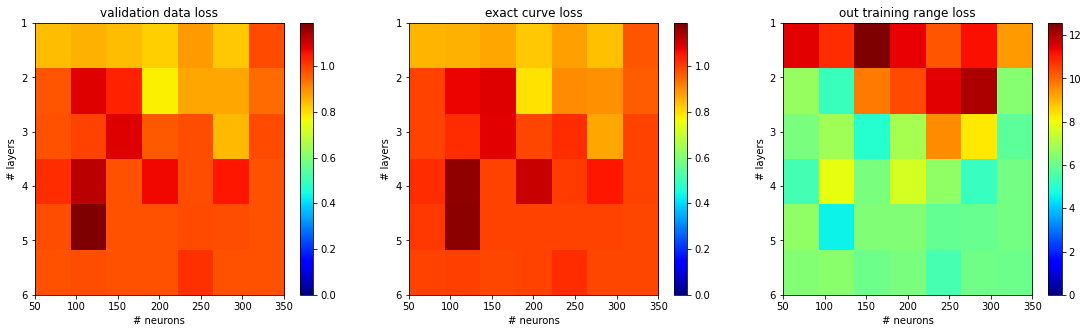




BEST MODEL
best number of layers= 2   best number of neurons 200


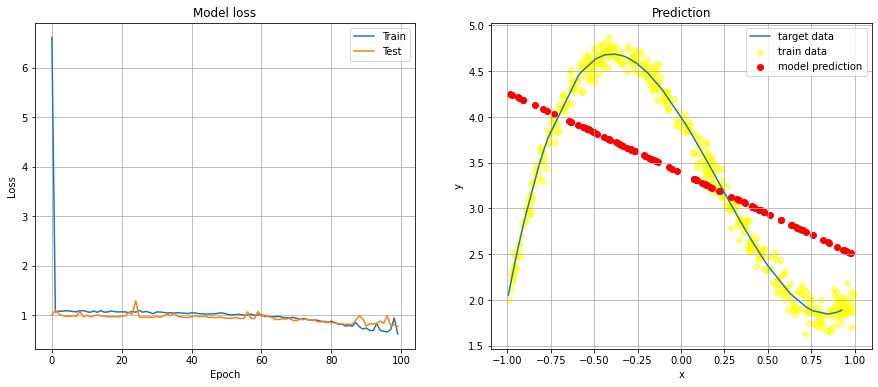

In [21]:
plot(NN4)

PREDICTION OUT OF TRAINING RANGE

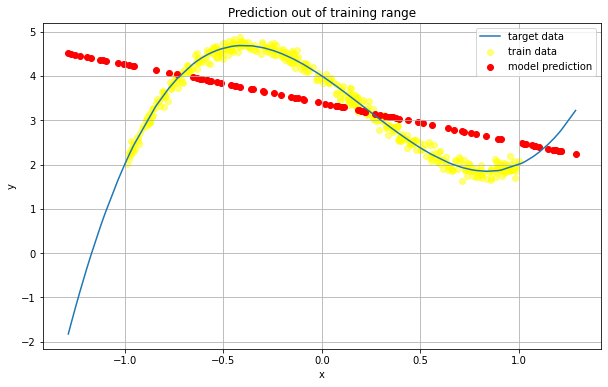

In [22]:
plot_out(NN4)

---------------------
## Activation function: SIGMOID
- opt=sdg
- loss= mse
- act =sigmoid

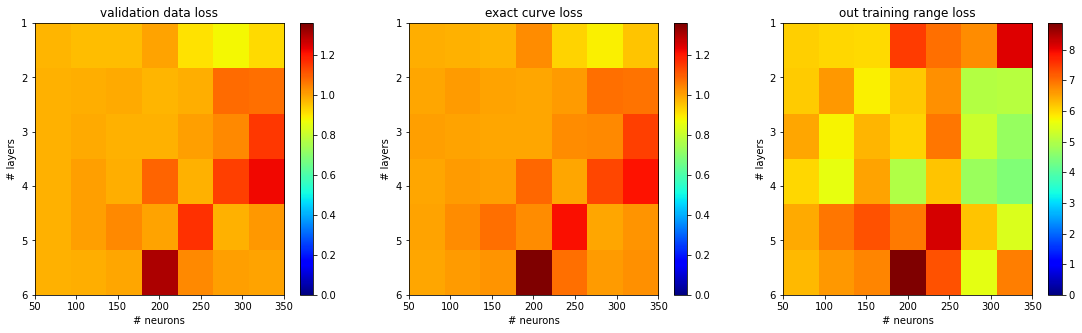




BEST MODEL
best number of layers= 1   best number of neurons 300


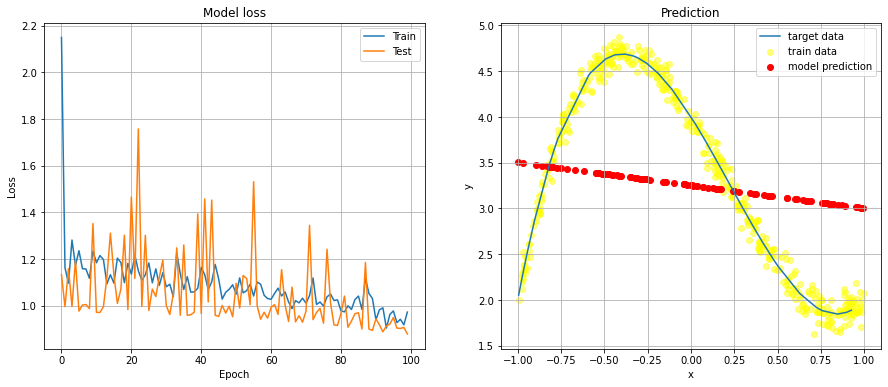

In [23]:
plot(NN5)

PREDICTION OUT OF TRAINING RANGE

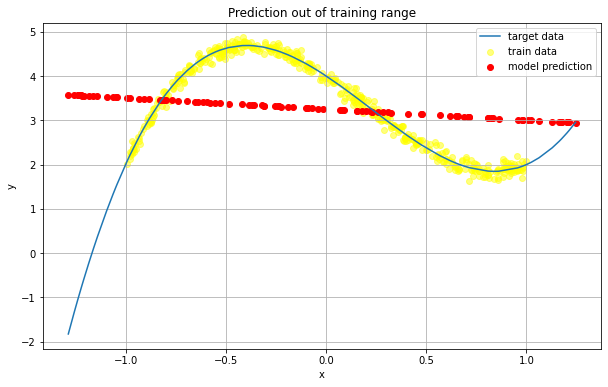

In [24]:
plot_out(NN5)

The different test showed that for the activation functions RELU, ELU and TANH the loss generally decreases as N_ neurons and N_layers decreases (as one would expect), with the best activation being RELU.
The other two activation function (SOFTPLUS and SIGMOID) doesen't work.

Wee also see that none of the above neural network can predict the target function outside the training range and that there isn't a different range were the NN can predict better in the outside range respect to the range of values where can predict in the training range

--------------
--------
## Different Optimizer and Loss
I'll now try to change the optimizer and the loss using the relu activation function.
I'll also change the values of 
- N_layers=[5,6,7,8,9]
- N_neurons=[200,250,300,350,400,450,500,550]

In [ ]:
N_layers=np.arange(1,7, 1)
N_neurons=np.arange(50,400, 50)
print('N_layers=',N_layers)
print('N_neurons=',N_neurons)


N_layers= [1 2 3 4 5 6]
N_neurons= [ 50 100 150 200 250 300 350]


## OPTIMIZER: ADAGRAD
- opt=adagrad
- loss= mse
- act =relu

In [ ]:
opt="adagrad"
loss='mse'
act='relu'
NN2_1=Find_best_NN(N_layers, N_neurons, opt, loss, act)

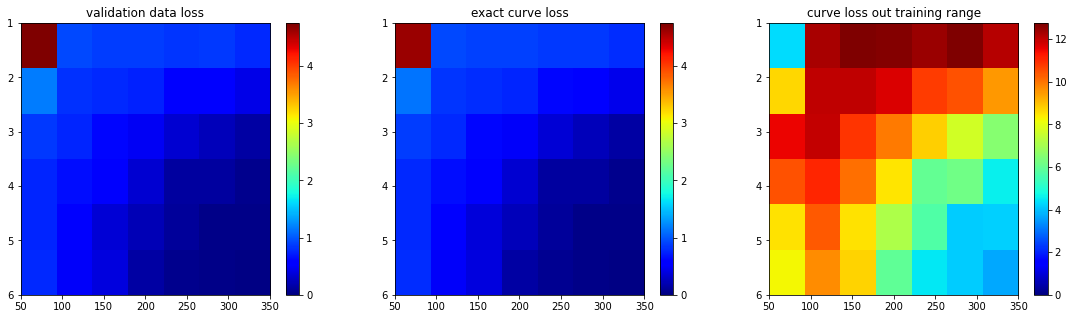




BEST MODEL
best number of layers= 6   best number of neurons 350


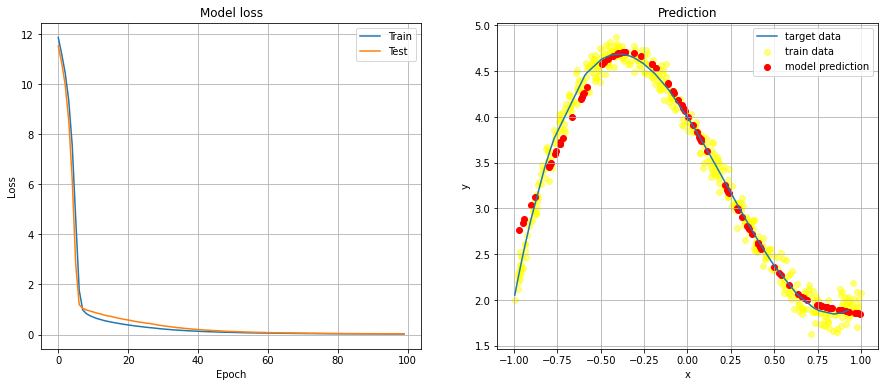

In [ ]:
 plot(NN2_1)

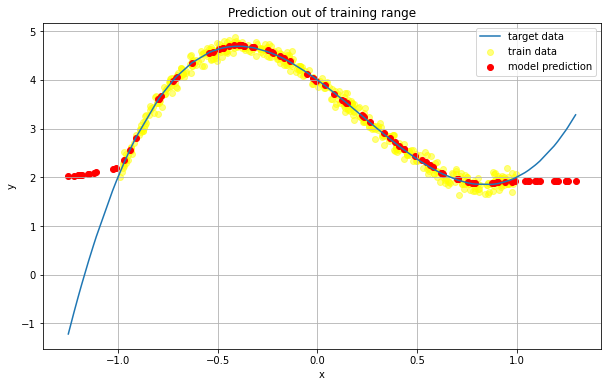

In [ ]:
plot_out(NN2_1)

## OPTIMIZER: ADADELTA
- opt=adagrad
- loss= mse
- act =relu

In [ ]:
opt="adadelta"
loss='mse'
act='relu'
NN2_2=Find_best_NN(N_layers, N_neurons, opt, loss, act)

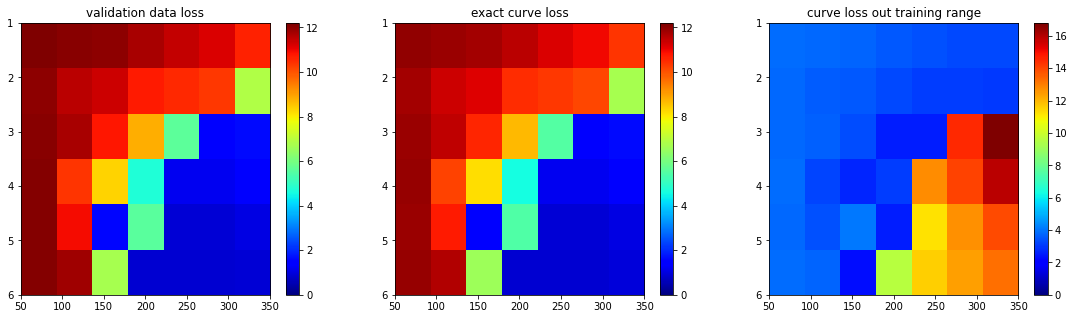




BEST MODEL
best number of layers= 6   best number of neurons 200


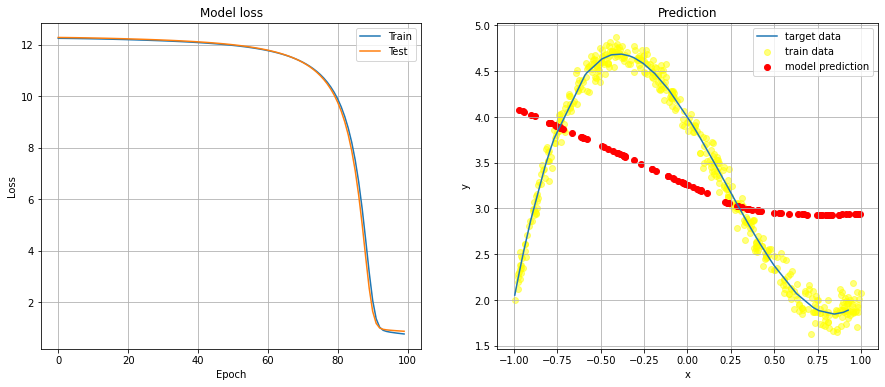

In [ ]:
 plot(NN2_2)

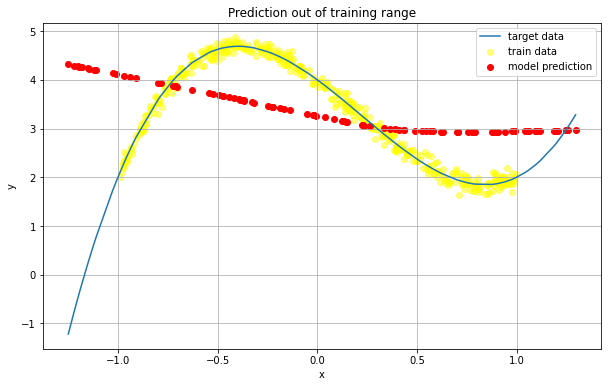

In [ ]:
plot_out(NN2_2)

## OPTIMIZER: ADAM
- opt=adam
- loss= mse
- act =relu

In [ ]:
opt="adam"
loss='mse'
act='relu'
NN2_3=Find_best_NN(N_layers, N_neurons, opt, loss, act)

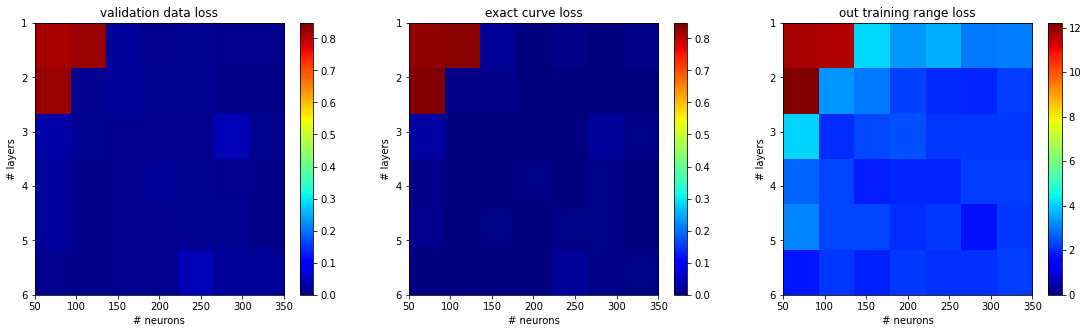




BEST MODEL
best number of layers= 2   best number of neurons 350


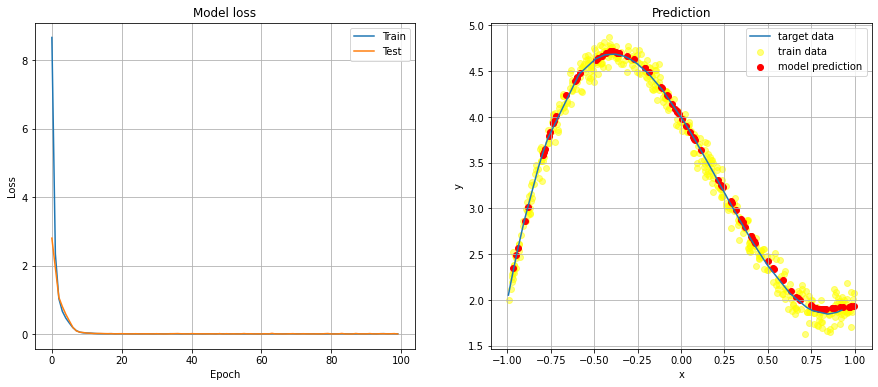

In [36]:
 plot(NN2_3)

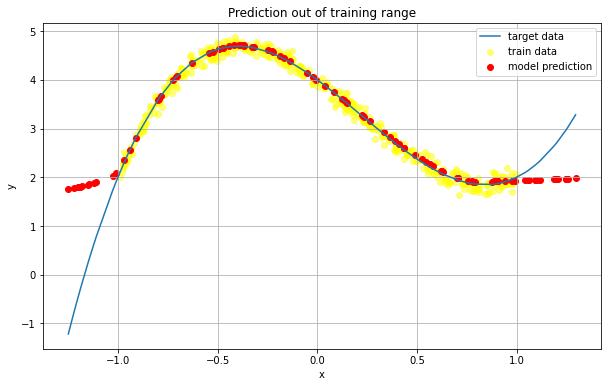

In [34]:
plot_out(NN2_3)

The main difference with respect to the previos cases seems to be that the loss evolution is smoother, and this is probably due to the adaptive properties of the optimizer

------------
------------
## CHANGE IN LOSS

## LOSS: mean absolut error
- opt=sdg
- loss= mae
- act =relu

In [ ]:
opt="sgd"
loss='mae'
act='relu'
NN3_1=Find_best_NN(N_layers, N_neurons, opt, loss, act)

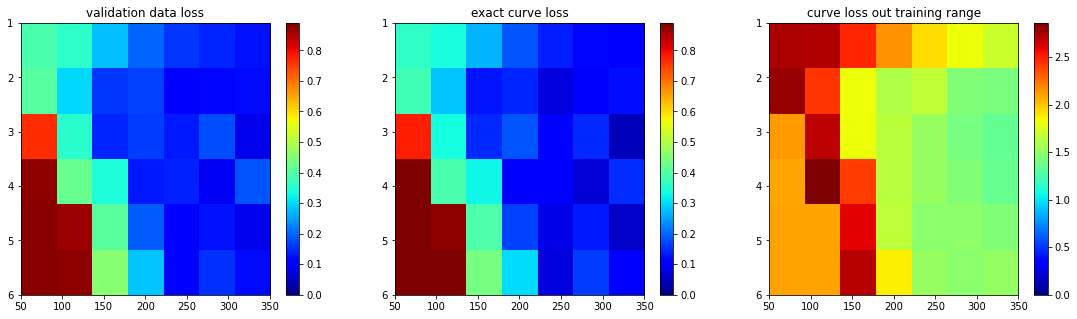




BEST MODEL
best number of layers= 3   best number of neurons 350


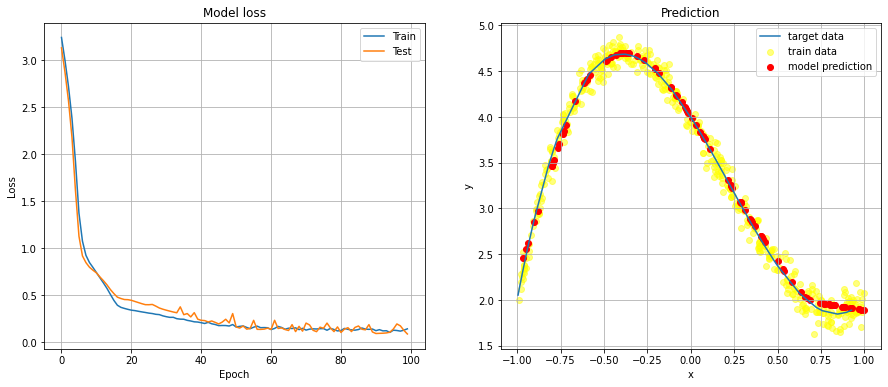

In [ ]:
plot(NN3_1)

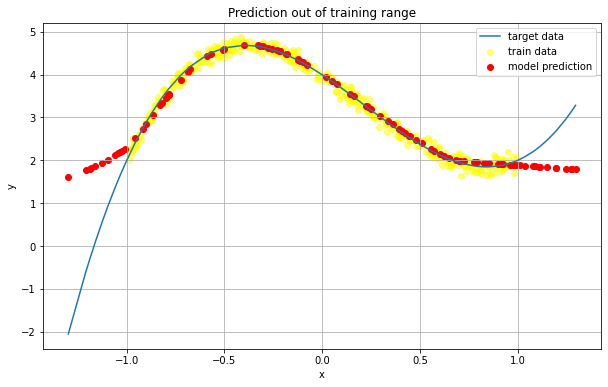

In [ ]:
plot_out(NN3_1)

## LOSS: mean squared logaritmic error
- opt=adam
- loss= mae
- act =relu

In [ ]:
opt="adam"
loss='msle'
act='relu'
NN3_2=Find_best_NN(N_layers, N_neurons, opt, loss, act)

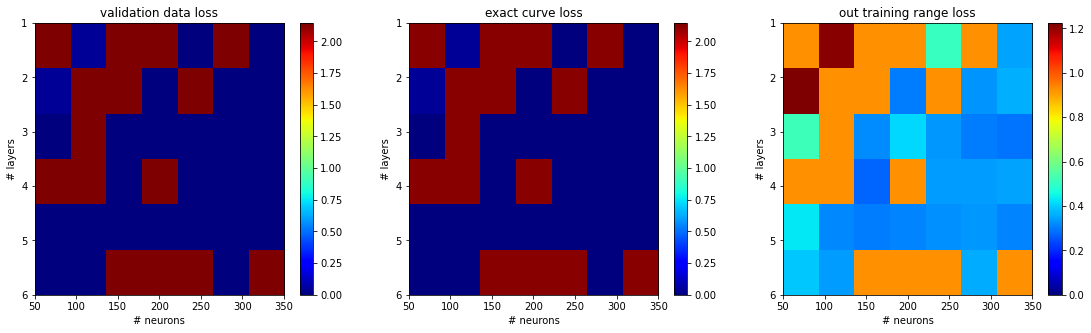




BEST MODEL
best number of layers= 2   best number of neurons 350


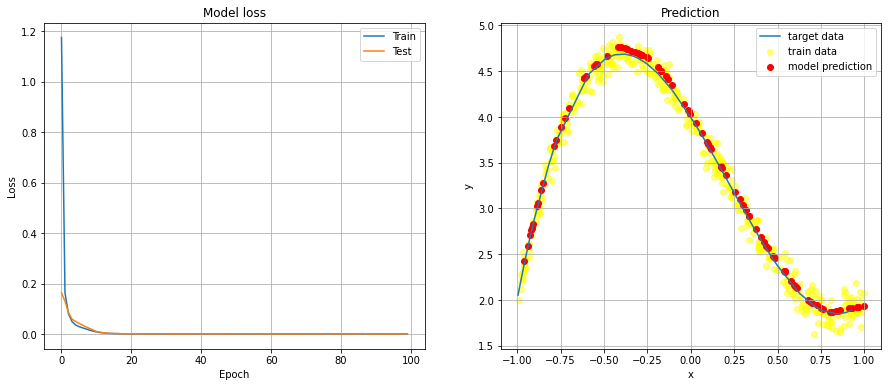

In [37]:
plot(NN3_2)

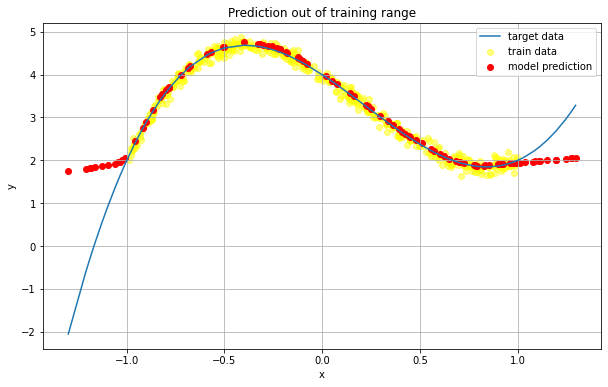

In [38]:
plot_out(NN3_2)